# **Image Alignment**

>Detect corners → describe them → match them → compute homography → warp image → align scanned form.

**Theory**

A **Homography** tranforms a sqaure to a arbitrary quad.

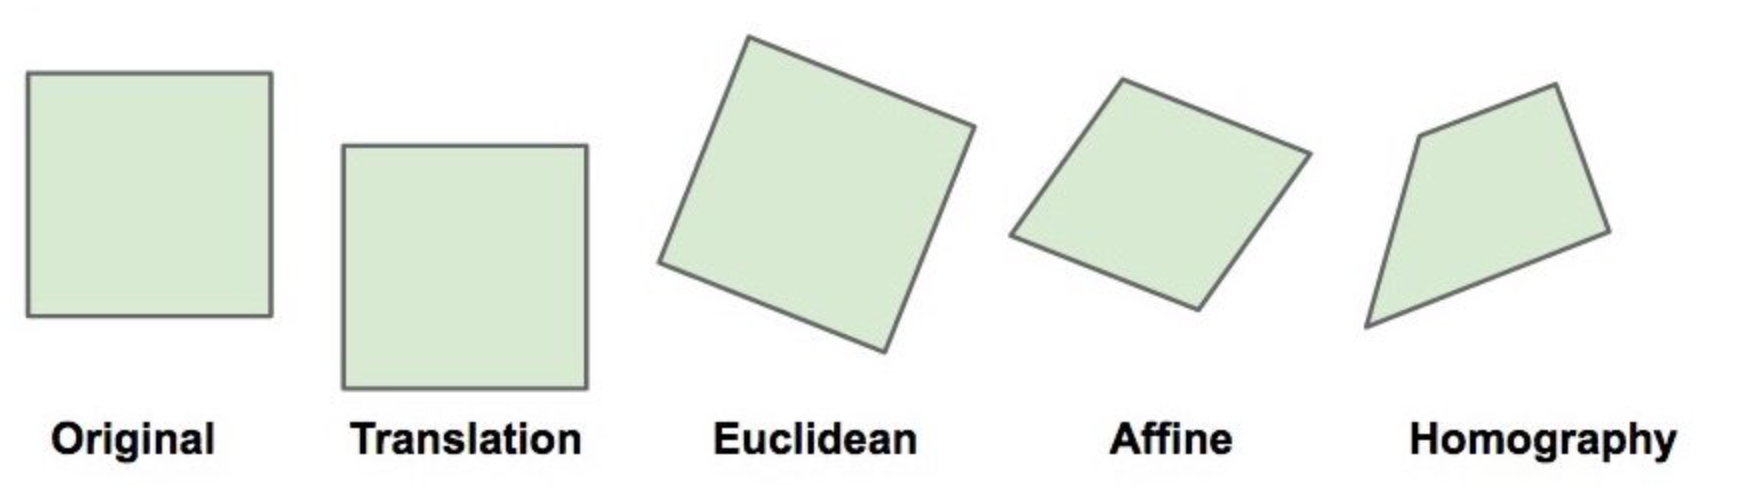

In [9]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline


# **Downloadng Assets**

In [10]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [11]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# **Step 1: Read Tempalate and Scanned Image**

In [12]:
# Read reference image
reffilename="form.jpg"
print("Reading reference image:",reffilename)
im1=cv2.imread(reffilename,cv2.IMREAD_COLOR)
im1=cv2.cvtColor(im1,cv2.COLOR_BGR2RGB)

# Read image to aligned
imfilename="scanned-form.jpg"
print("Reading image to aline",imfilename)
im2=cv2.imread(imfilename,cv2.IMREAD_COLOR)
im2=cv2.cvtColor(im2,cv2.COLOR_BGR2RGB)

Reading reference image: form.jpg
Reading image to aline scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

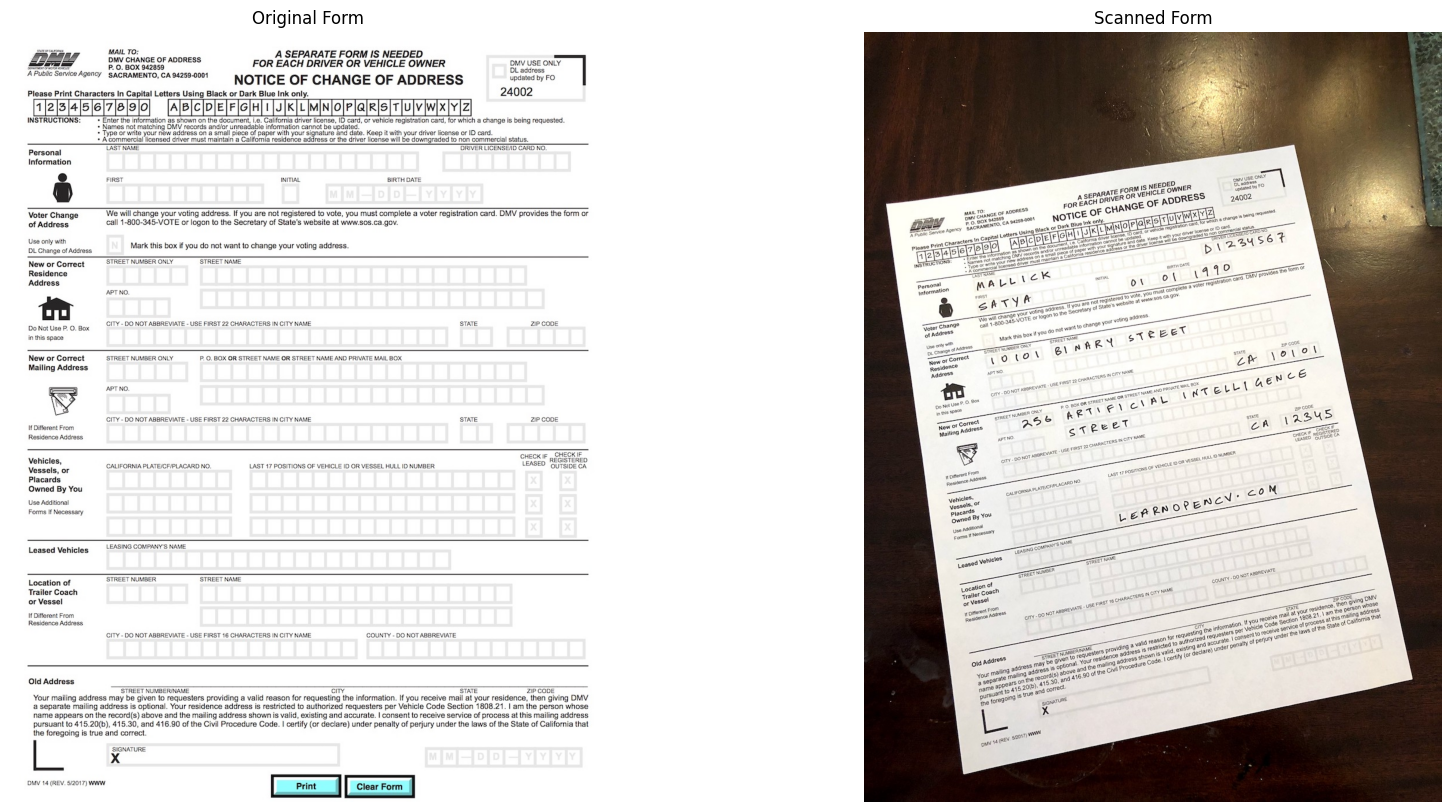

In [15]:
# Display Images

plt.figure(figsize=[20,10])
plt.subplot(121);plt.axis("off");plt.imshow(im1);plt.title("Original Form")
plt.subplot(122);plt.axis("off");plt.imshow(im2);plt.title("Scanned Form")

# **Step 2: Find keypoints in both images**
Think of keypoints as corner points that are stable under image transformations

In [23]:
# Convert images to grayscale
im1_gray=cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray=cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

# Detect ORB features (Detects corner points hence helping in comparision) and compute descriptors.
MAX_NUM_FEATURES=500
orb=cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1,descriptors1=orb.detectAndCompute(im1_gray,None)
keypoints2,descriptors2=orb.detectAndCompute(im2_gray,None)

# Display
im1_display=cv2.drawKeypoints(im1,keypoints1,outImage=np.array([]),color=(255,0,0),
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


Text(0.5, 1.0, 'Scanned Form')

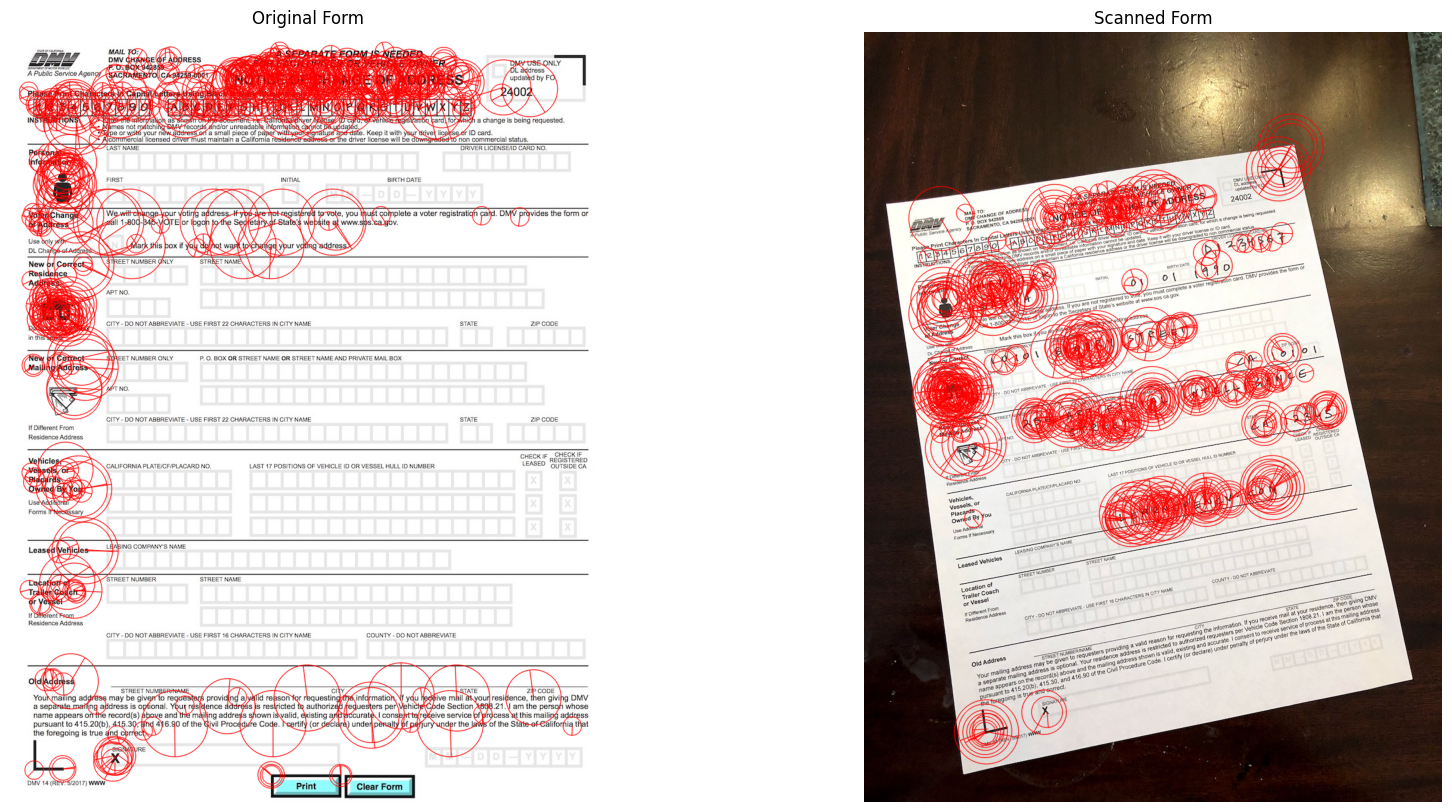

In [24]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form")

# **Step 3: Match keypoints in the two image**

In [25]:
# Match feature
matcher=cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuple are immutable objects.
matches=list(matcher.match(descriptors1,descriptors2,None))

# Sort matches by score
matches.sort(key=lambda x:x.distance,reverse=False)

# Remove not so good matches
numGoodMatches=int(len(matches)*0.1)
matches=matches[:numGoodMatches]


Text(0.5, 1.0, 'Original Form')

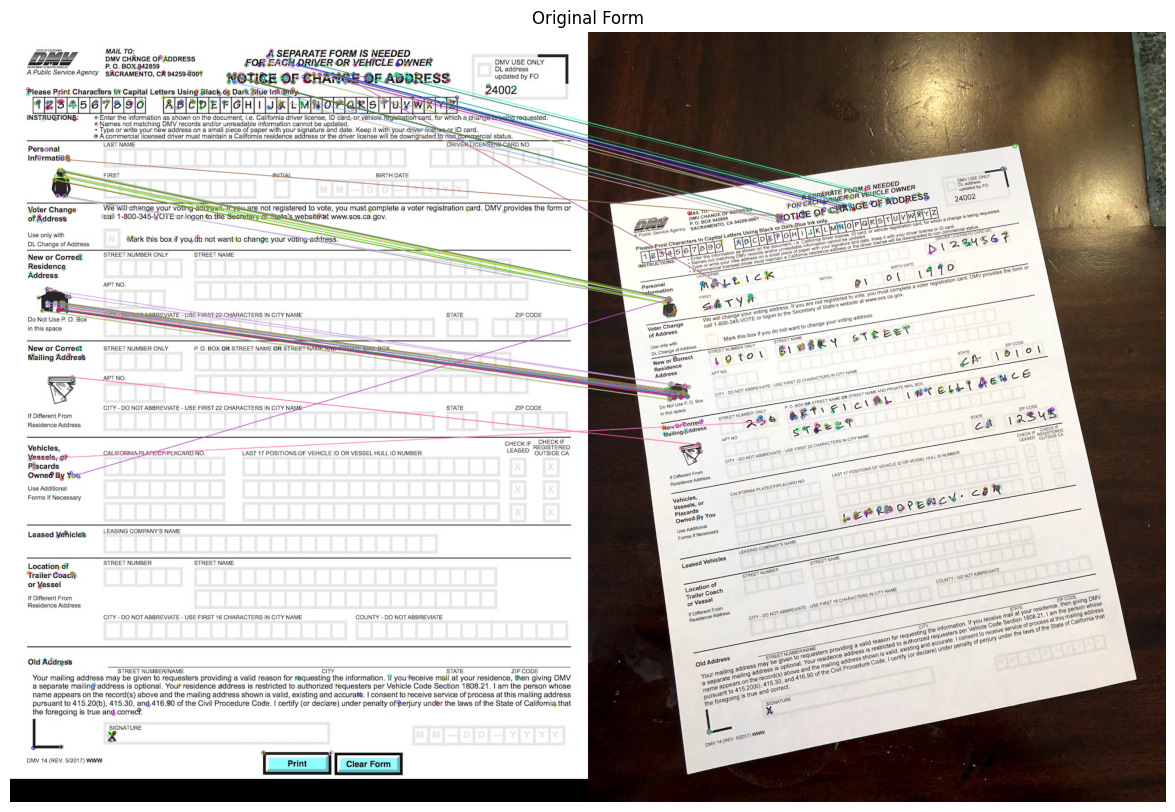

In [26]:
# Draw top matches
im_matches=cv2.drawMatches(im1,keypoints1,im2,keypoints2,matches,None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

# **Step 4: Find Homography**

In [27]:
# Extract location of good matches
points1=np.zeros((len(matches),2),dtype=np.float32)
points2=np.zeros((len(matches),2),dtype=np.float32)

for i,match in enumerate(matches):
    points1[i,:]=keypoints1[match.queryIdx].pt
    points2[i,:]=keypoints2[match.trainIdx].pt

# Find homography
h,mask=cv2.findHomography(points2,points1,cv2.RANSAC)

# **Step 5: Warp Image**

Text(0.5, 1.0, 'Scanned Form')

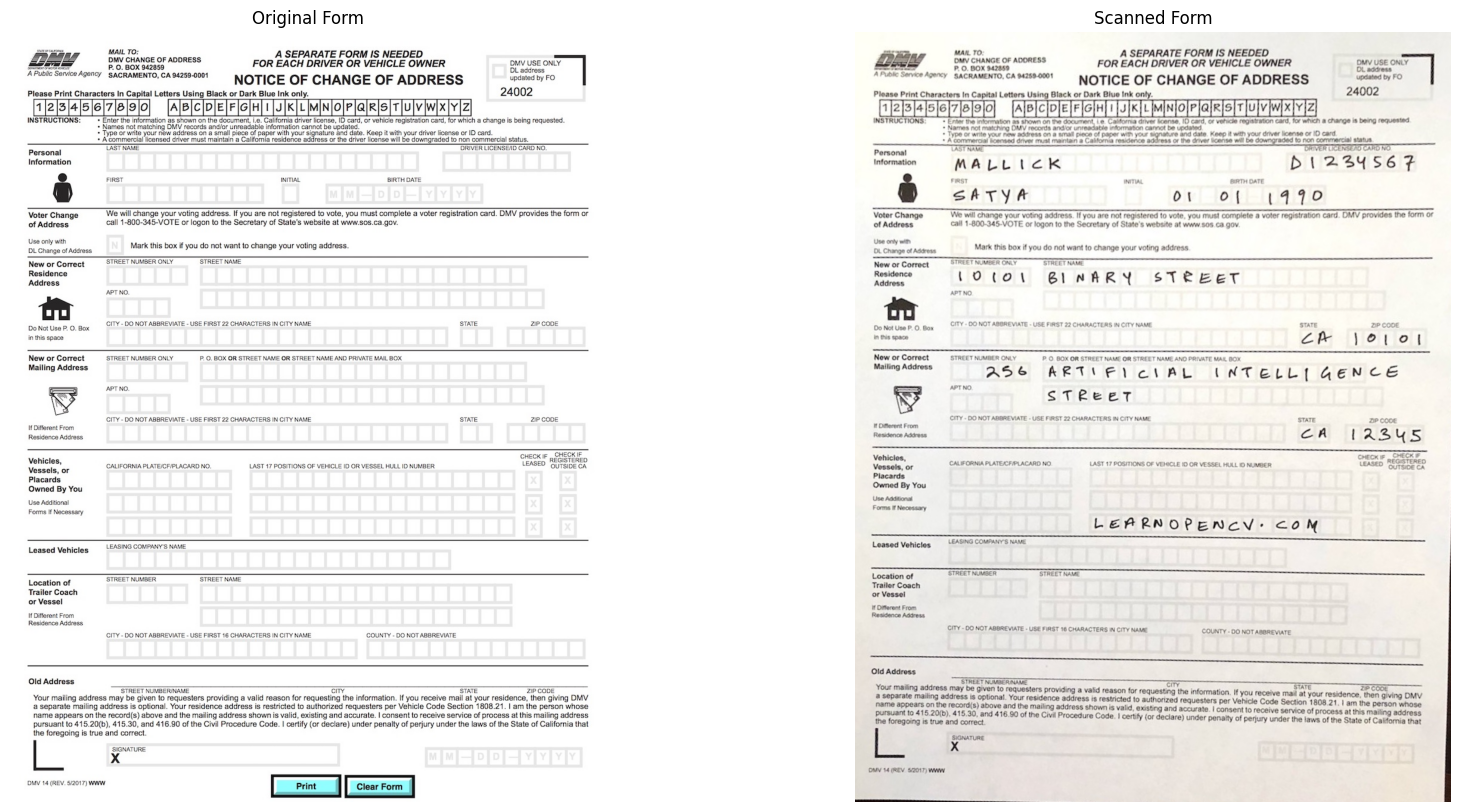

In [29]:
# Use homography to wrap img
height,width,channels=im1.shape
im2_reg=cv2.warpPerspective(im2,h,(width,height))

# Display results
plt.figure(figsize=[20,10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")

# **FULL ORB -> HOMOGRAPHY PIPELINE**

| Step | Code / Term             | What It Does (Simple)              | Why It’s Needed                        |
| ---- | ----------------------- | ---------------------------------- | -------------------------------------- |
| 1    | `cvtColor(...BGR2GRAY)` | Converts image to grayscale        | Features depend on intensity           |
| 2    | `ORB_create(N)`         | Creates ORB detector               | Finds fast, rotation-invariant corners |
| 3    | `detectAndCompute()`    | Detects keypoints + descriptors    | Core feature extraction                |
| 4    | `keypoints`             | Stores corner location & angle     | Needed for matching & homography       |
| 5    | `descriptors`           | Binary fingerprint of keypoints    | Used to compare features               |
| 6    | `matches`               | Pairs similar descriptors          | Links same points in both images       |
| 7    | `queryIdx`              | Index of keypoint in image-1       | Tells where match comes from           |
| 8    | `trainIdx`              | Index of keypoint in image-2       | Tells where match goes                 |
| 9    | `np.zeros((N,2))`       | Allocates memory for point storage | Required format for homography         |
| 10   | `.pt`                   | Extracts (x, y) coordinate         | Homography needs coordinates           |
| 11   | `points1[i,:]`          | Stores matched points of image-1   | Destination reference                  |
| 12   | `points2[i,:]`          | Stores matched points of image-2   | Source reference                       |
| 13   | `findHomography()`      | Computes transformation matrix     | Aligns two images geometrically        |
| 14   | `cv2.RANSAC`            | Rejects wrong matches              | Makes alignment robust                 |
| 15   | `h`                     | 3×3 homography matrix              | Defines perspective mapping            |
| 16   | `mask`                  | Inlier/outlier match indicator     | Filters bad matches                    |
| 17   | `warpPerspective()`     | Applies homography to image        | Aligns scanned to original             |
| 18   | `(width, height)`       | Output image size                  | Matches reference image                |
| 19   | `im2_reg`               | Registered (aligned) image         | Final corrected output                 |
| 20   | `plt.subplot()`         | Side-by-side display               | Visual verification                    |
